In [65]:
# ref: https://www.kaggle.com/c/santander-customer-satisfaction

In [66]:
import os

os.chdir('/content/drive/MyDrive/아시아경제 Fintech 과정/ML/santander_customer_satisfaction')

# 산탄데르 은행 고객 만족 예측

In [97]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
#from lightgbm import plot_importance

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import  f1_score, roc_auc_score

### 데이터 로딩

In [68]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [69]:
test_id = test.ID # submission에 제출할 ID 저장

In [70]:
train.shape, test.shape

((76020, 371), (75818, 370))

In [71]:
train.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,...,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,300.0,122.22,300.0,240.75,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3.00,2.07,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,0.0,195.0,195.0,0.0,0.0,195.0,0.0,0.0,195.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,91.56,138.84,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,...,40501.08,13501.47,0.0,0.0,0.0,0.0,0.0,0.0,85501.89,85501.89,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [72]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


### 타겟변수 살펴보기

In [73]:
train['TARGET'].value_counts()

0    73012
1     3008
Name: TARGET, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


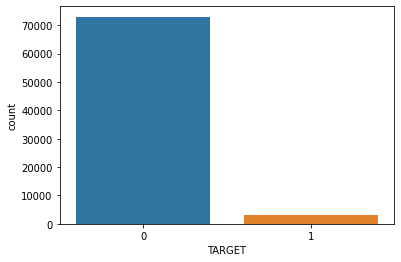

In [74]:
sns.countplot(train['TARGET'])

In [75]:
unsatisfied_cnt = train[train['TARGET'] == 1]['TARGET'].count()
print(f'불만족 고객의 비율: {(unsatisfied_cnt/train.shape[0])*100:.2f}%')

불만족 고객의 비율: 3.96%


타켓변수의 비율이 매우 불균형함

In [76]:
train.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,...,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.0,76020.0,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.0,76020.000000,76020.000000,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,3.160715,68.803937,113.056934,68.205140,113.225058,137.242763,68.618087,113.792410,140.403479,5.477676,0.011458,0.003762,0.0,0.0,0.958024,0.663760,0.000105,0.000026,0.032833,0.028598,0.067522,0.045462,0.052249,0.042936,0.041476,0.010168,0.009997,0.000026,0.000026,0.050855,...,1077.256756,1048.856447,68.275452,9.505287,124.620962,110.026575,3.997023e+03,613.534443,5.703008e+03,4.401002e+03,3639.419939,556.184178,4852.261814,3857.848542,771.227449,162.170439,9.569502e+02,7.509563e+02,0.175324,0.0,0.513023,0.344174,9.117181e+01,3.646318e+01,1.310316e+02,1.092169e+02,0.213071,0.001910,0.253907,0.186630,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,95.268204,319.605516,512.154823,531.897917,950.086398,697.712596,535.473750,953.578624,712.767240,465.391149,0.106425,0.061221,0.0,0.0,0.200535,0.472425,0.010258,0.005129,0.178202,0.166674,0.250925,0.208316,0.222531,0.202714,0.199390,0.100325,0.099486,0.005129,0.005129,0.219703,...,9614.906985,8189.948852,1733.838226,519.389157,2205.249804,1935.305713,3.777314e+04,9292.752726,4.620254e+04,3.550718e+04,26359.174223,7182

In [77]:
train['var3'].value_counts()[:10]

 2         74165
 8           138
-999999      116
 9           110
 3           108
 1           105
 13           98
 7            97
 4            86
 12           85
Name: var3, dtype: int64

대부분이 값 2인데 -999999인 이상치를 볼 수 있다

In [78]:
# -999999 값이 학습에 영향을 줄 수 있으므로 2로 값 대체
train.replace(-999999, 2, inplace=True)

# 유니크한 값인 ID 피처 삭제
train.drop('ID', axis=1, inplace=True)
test.drop('ID', axis=1, inplace=True)

In [79]:
y_labels = train['TARGET']
X_features = train.drop('TARGET', axis=1)

In [80]:
X_features.shape, y_labels.shape

((76020, 369), (76020,))

In [81]:
# stratify = y_labels: k=fold를 사용해 불균형한 값들을 자동으로 균형맞게 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, stratify=y_labels, random_state=125)

train_cnt = y_train.count()
test_cnt = y_test.count()

print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)

학습 세트 레이블 값 분포 비율
0    0.960438
1    0.039562
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.960438
1    0.039562
Name: TARGET, dtype: float64


In [82]:
xgb_clf = XGBClassifier(n_estimators=500, random_state=125)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습
xgb_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])


[0]	validation_0-auc:0.786749	validation_1-auc:0.7877
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.803984	validation_1-auc:0.811126
[2]	validation_0-auc:0.810743	validation_1-auc:0.819245
[3]	validation_0-auc:0.813285	validation_1-auc:0.824064
[4]	validation_0-auc:0.814081	validation_1-auc:0.823328
[5]	validation_0-auc:0.813591	validation_1-auc:0.823623
[6]	validation_0-auc:0.81538	validation_1-auc:0.823713
[7]	validation_0-auc:0.815351	validation_1-auc:0.823429
[8]	validation_0-auc:0.815304	validation_1-auc:0.823229
[9]	validation_0-auc:0.816034	validation_1-auc:0.823564
[10]	validation_0-auc:0.815188	validation_1-auc:0.823287
[11]	validation_0-auc:0.815667	validation_1-auc:0.823354
[12]	validation_0-auc:0.816648	validation_1-auc:0.823971
[13]	validation_0-auc:0.817234	validation_1-auc:0.825239
[14]	validation_0-auc:0.818592	validation_1-auc:0.826904


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=125,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [83]:
xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1], average='macro')
print(f'ROC AUC: {xgb_roc_score:.4f}')

ROC AUC: 0.8515


In [89]:
params = {
    'max_depth': [5,7],
    'min_child_weight': [1,3],
    'colsample_bytree': [0.5, 0.75]
}

gridcv = GridSearchCV(xgb_clf, param_grid=params) # 빠른 학습을 위해 cv 지정 X
gridcv.fit(X_train, y_train, early_stopping_rounds=50, eval_metric="auc", eval_set=[(X_test, y_test)])

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[19]	validation_0-auc:0.822745
[20]	validation_0-auc:0.825522
[21]	validation_0-auc:0.829441
[22]	validation_0-auc:0.82669
[23]	validation_0-auc:0.831439
[24]	validation_0-auc:0.834293
[25]	validation_0-auc:0.837379
[26]	validation_0-auc:0.836935
[27]	validation_0-auc:0.836094
[28]	validation_0-auc:0.838062
[29]	validation_0-auc:0.839958
[30]	validation_0-auc:0.839574
[31]	validation_0-auc:0.839204
[32]	validation_0-auc:0.840535
[33]	validation_0-auc:0.839521
[34]	validation_0-auc:0.841116
[35]	validation_0-auc:0.840566
[36]	validation_0-auc:0.839468
[37]	validation_0-auc:0.8388
[38]	validation_0-auc:0.840671
[39]	validation_0-auc:0.842067
[40]	validation_0-auc:0.843129
[41]	validation_0-auc:0.844301
[42]	validation_0-auc:0.845174
[43]	validation_0-auc:0.844725
[44]	validation_0-auc:0.845857
[45]	validation_0-auc:0.846423
[46]	validation_0-auc:0.847101
[47]	validation_0-auc:0.84754
[48]	validation_0-auc:0.847719
[49]	validation_0-auc:0.848399
[50]	va

GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=500, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=125, reg_alpha=0,
                                     reg_lambda=1, scale_pos_weight=1,
                                     seed=None, silent=None, subsample=1,
                                     verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [0.5, 0.75], 'max_depth': [5, 7],
                         'min_child_weight': [1, 3]},
  

In [90]:
print("GridSearchCV 최적의 파라미터:", gridcv.best_params_)

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1], average='macro')
print(f'ROC AUC: {xgb_roc_score:.4f}')

GridSearchCV 최적의 파라미터: {'colsample_bytree': 0.75, 'max_depth': 5, 'min_child_weight': 3}
ROC AUC: 0.8515


In [103]:
xgb_clf = XGBClassifier(n_estimators=1000, random_state=125, learning_rate=0.02, max_depth= 5,\
                        min_child_weight= 3, colsample_bytree=0.75, reg_alpha=0.03)

xgb_clf.fit(X_train, y_train, early_stopping_rounds=200, eval_metric="auc", eval_set=[(X_test, y_test)])

[0]	validation_0-auc:0.74178
Will train until validation_0-auc hasn't improved in 200 rounds.
[1]	validation_0-auc:0.796976
[2]	validation_0-auc:0.796335
[3]	validation_0-auc:0.810178
[4]	validation_0-auc:0.815788
[5]	validation_0-auc:0.821003
[6]	validation_0-auc:0.823561
[7]	validation_0-auc:0.825161
[8]	validation_0-auc:0.825334
[9]	validation_0-auc:0.827027
[10]	validation_0-auc:0.829106
[11]	validation_0-auc:0.829571
[12]	validation_0-auc:0.829644
[13]	validation_0-auc:0.830952
[14]	validation_0-auc:0.828473
[15]	validation_0-auc:0.827757
[16]	validation_0-auc:0.82813
[17]	validation_0-auc:0.828562
[18]	validation_0-auc:0.826104
[19]	validation_0-auc:0.826674
[20]	validation_0-auc:0.827527
[21]	validation_0-auc:0.828424
[22]	validation_0-auc:0.827222
[23]	validation_0-auc:0.827644
[24]	validation_0-auc:0.828952
[25]	validation_0-auc:0.830316
[26]	validation_0-auc:0.830449
[27]	validation_0-auc:0.830433
[28]	validation_0-auc:0.83193
[29]	validation_0-auc:0.832371
[30]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.75, gamma=0,
              learning_rate=0.02, max_delta_step=0, max_depth=5,
              min_child_weight=3, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=125,
              reg_alpha=0.03, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [104]:
xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1], average='macro')
print(f'ROC AUC: {xgb_roc_score:.4f}')

ROC AUC: 0.8530


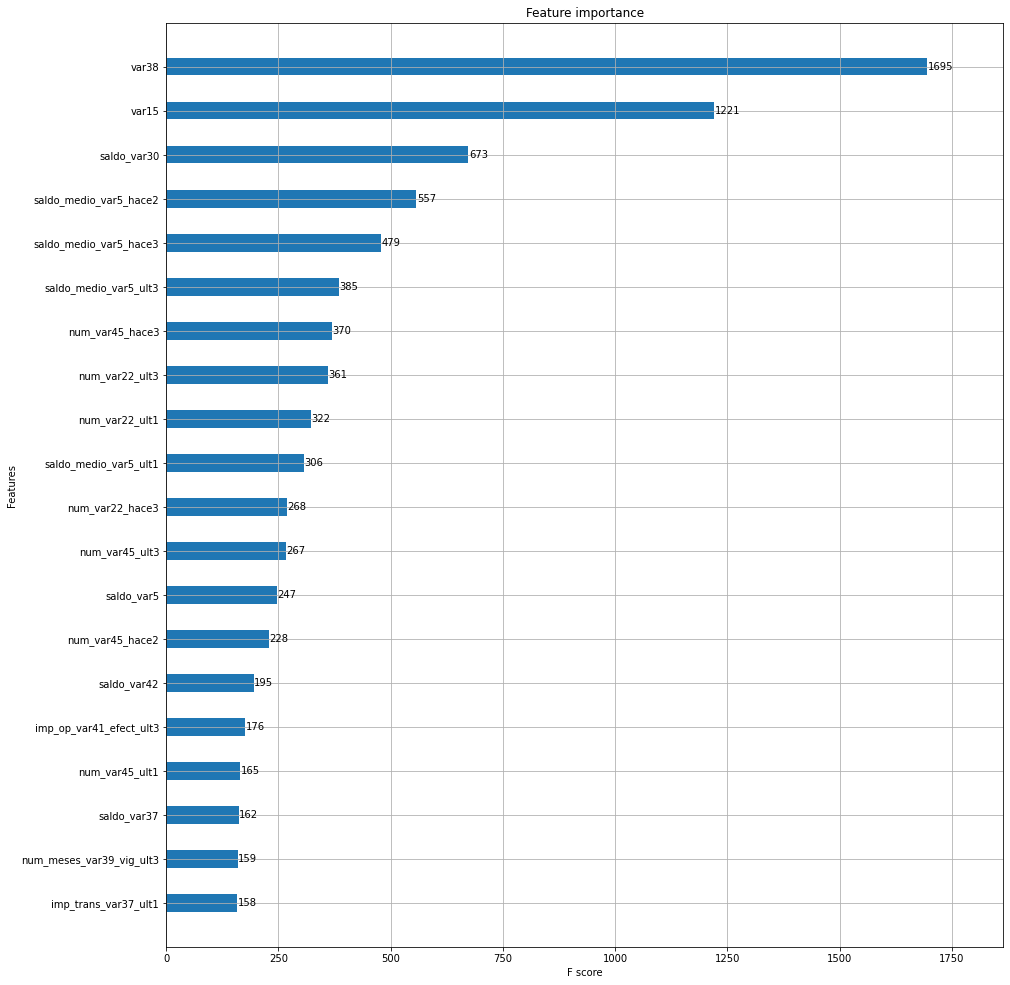

In [108]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(15, 17))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)

In [109]:
pred_proba = xgb_clf.predict_proba(test)

submission = pd.DataFrame({"ID":test_id, "TARGET": pred_proba[:,1]})
submission.to_csv("submission.csv", index=False)